# Programming Language Correlation

This sample notebook demonstrates working with GitHub activity, which has been made possible via the publicly accessible GitHub Timeline BigQuery dataset via the [BigQuery Sample Tables](https://cloud.google.com/bigquery/sample-tables/).

Here is the question that this notebook tackles: "_How likely are you to program in X, if you program in Y?_" For example, this might be an input into an repository exploration/recommendation/search tool to personalize the results based on your own contributions.

It is based on an example published at http://datahackermd.com/2013/language-use-on-github/. It counts pushes or commits made by all users across all repositories on GitHub and their associated repository languages to determine the correlation between languages.

Related Links:

* [Google BigQuery](https://cloud.google.com/bigquery/what-is-bigquery)
* BigQuery [SQL reference](https://cloud.google.com/bigquery/query-reference)
* Python [Pandas](http://pandas.pydata.org/) for data analysis
* Python [matplotlib](http://matplotlib.org/) for data visualization

In [2]:
import datalab.bigquery as bq
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd

# Understanding the GitHub Timeline

We're going to work with the GitHub Archive project data. It contains all github events (commits, pushes, forks, watches, etc.) along with metadata about the events (e.g., user, time, place). The schema and sample data will help use to further understand this dataset.

In [3]:
%%bigquery schema --table "publicdata:samples.github_timeline"

The GitHub timeline is a large dataset. A quick lookup of table metadata gives us the row count.

In [4]:
table = bq.Table('publicdata:samples.github_timeline')
table.metadata.rows

6219749

With over 290 million events, it is important to be able to sample the data. The sample method allows us to sample tables or queries.

In [5]:
table.sample(fields=['repository_name',
                     'repository_language',
                     'created_at',
                     'type'])

repository_name,repository_language,created_at,type
Static-Site-Templates,,2012-04-02 22:09:29,PushEvent
Vanilla,Java,2012-04-02 22:09:29,PushEvent
swe2_backoffice,C#,2012-04-02 22:09:29,IssuesEvent
dotconf,Python,2012-04-02 22:09:29,PushEvent
tweepy,Python,2012-04-02 22:09:29,CreateEvent


# Querying the Data

The first step in our analysis to correlate languages is retrieving the appropriate slice of data.

We'll need to retrieve the list of PushEvents from the timeline. This is a large list of events, and there are several ways to get a more manageable resultset:

* Limiting the analysis to the top 25 languages (from an otherwise long list of languages that simply add noise).
* Limiting the analysis to just pushes made during 1 year time window; we will use 2012.
* Further sampling to get a small, but still interesting sample set to further analyze for correlation.

In [6]:
%%sql --module github

DEFINE QUERY popular_languages
SELECT repository_language AS language, COUNT(repository_language) as pushes
FROM [publicdata:samples.github_timeline]
WHERE type = 'PushEvent'
  AND repository_language != ''
  AND PARSE_UTC_USEC(created_at) >= TIMESTAMP("2012-01-01")
  AND PARSE_UTC_USEC(created_at) < TIMESTAMP("2013-01-01")
GROUP BY language
ORDER BY pushes DESC
LIMIT 25

DEFINE QUERY pushes
SELECT timeline.actor AS user,
       timeline.repository_language AS language,
       COUNT(timeline.repository_language) AS pushes
FROM [publicdata:samples.github_timeline] AS timeline
JOIN $popular_languages AS languages
  ON timeline.repository_language = languages.language
WHERE type = 'PushEvent'
  AND PARSE_UTC_USEC(created_at) >= TIMESTAMP("2012-01-01") 
  AND PARSE_UTC_USEC(created_at) < TIMESTAMP("2013-01-01") 
GROUP BY user, language

DEFINE QUERY pushes_sample
SELECT user, language, pushes
FROM $pushes
WHERE ABS(HASH(user)) % 100 < 5

## Checking the Results

In [7]:
bq.Query(github.popular_languages).results()

language,pushes
JavaScript,455158
Java,341750
Ruby,324837
Python,261187
PHP,246018
C++,163494
C,161677
Shell,75076
C#,60039
Objective-C,45619


In [8]:
query = bq.Query(github.pushes_sample)
print query.sql

query.results()

SELECT user, language, pushes
FROM (SELECT timeline.actor AS user,
       timeline.repository_language AS language,
       COUNT(timeline.repository_language) AS pushes
FROM [publicdata:samples.github_timeline] AS timeline
JOIN (SELECT repository_language AS language, COUNT(repository_language) as pushes
FROM [publicdata:samples.github_timeline]
WHERE type = 'PushEvent'
  AND repository_language != ''
  AND PARSE_UTC_USEC(created_at) >= TIMESTAMP("2012-01-01")
  AND PARSE_UTC_USEC(created_at) < TIMESTAMP("2013-01-01")
GROUP BY language
ORDER BY pushes DESC
LIMIT 25) AS languages
  ON timeline.repository_language = languages.language
WHERE type = 'PushEvent'
  AND PARSE_UTC_USEC(created_at) >= TIMESTAMP("2012-01-01") 
  AND PARSE_UTC_USEC(created_at) < TIMESTAMP("2013-01-01") 
GROUP BY user, language)
WHERE ABS(HASH(user)) % 100 < 5


user,language,pushes
botandrose,JavaScript,9
gjtorikian,JavaScript,294
diegok,Perl,6
pwmckenna,JavaScript,109
Jroland,C#,53
dubgeiser,VimL,26
panther-king,Python,16
benstraub,C,27
hsujeremyc,Java,8
luketurner,Python,25


# Analyzing the Data

The next step is to integrate the BigQuery SQL queries with the analysis capabilities provided by Python and pandas. The query defined earlier can easily be materialized into a pandas dataframe.

In [9]:
df = query.to_dataframe()

Great! We've successfully populated a pandas dataframe with our dataset. Let's dig into our dataset a further using the dataframe to see if our data makes sense.

In [10]:
df[:10]

,user,language,pushes
0,botandrose,JavaScript,9
1,gjtorikian,JavaScript,294
2,diegok,Perl,6
3,pwmckenna,JavaScript,109
4,Jroland,C#,53
5,dubgeiser,VimL,26
6,panther-king,Python,16
7,benstraub,C,27
8,hsujeremyc,Java,8
9,luketurner,Python,25


In [11]:
summary = df['user'].describe()

print 'DataFrame contains %d with %d unique users' % (summary['count'], summary['unique'])

DataFrame contains 10086 with 7370 unique users


Let's see who is the most polyglot user of the mix.

In [12]:
print '%s has contributions in %d languages' % (summary['top'], summary['freq'])

df[df['user'] == summary['top']]

fabriceleal has contributions in 7 languages


,user,language,pushes
1641,fabriceleal,PHP,1
2763,fabriceleal,Clojure,3
3005,fabriceleal,JavaScript,31
7285,fabriceleal,Shell,9
7352,fabriceleal,Ruby,1
8834,fabriceleal,C++,2
9582,fabriceleal,Python,20


## Reshaping the Data

So far, our results have multiple rows for each user -- specifically, one per language. The next step is to pivot that data, so that we have one row per user, and one column per language. The resulting matrix will be extremely sparse. We'll just fill in 0 (no pushes) for user/language pairs that have no data.

Pandas offers a built-in `pivot()` method, which helps here.

In [13]:
dfp = df.pivot(index = 'user', columns = 'language', values = 'pushes').fillna(0)
dfp

language,ActionScript,C,C#,C++,Clojure,CoffeeScript,Emacs Lisp,Erlang,Go,Groovy,...,Objective-C,PHP,Perl,Puppet,Python,R,Ruby,Scala,Shell,VimL
user,,,,,,,,,,,,,,,,,,,,,
0110,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01d55,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03knoppg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
0612800232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0bsidian,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0flash0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0
0xsanalp,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12345j,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
14to9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0


Now, compute the correlation for each pair of languages (again, built into the pandas library).

In [14]:
corr = dfp.corr(method = 'spearman')
corr

language,ActionScript,C,C#,C++,Clojure,CoffeeScript,Emacs Lisp,Erlang,Go,Groovy,...,Objective-C,PHP,Perl,Puppet,Python,R,Ruby,Scala,Shell,VimL
language,,,,,,,,,,,,,,,,,,,,,
ActionScript,1.000000,-0.019135,-0.016799,-0.018182,-0.006243,-0.007995,-0.009740,-0.005337,-0.005337,-0.006009,...,-0.006067,-0.011876,-0.012864,-0.005247,-0.012513,-0.006009,-0.032425,-0.009385,0.010914,-0.002805
C,-0.019135,1.000000,-0.052826,0.092608,-0.009098,-0.023345,0.004124,0.019077,0.004451,-0.014476,...,-0.013462,-0.079819,0.005915,-0.010940,-0.007664,-0.007452,-0.091067,-0.011783,0.065601,-0.017220
C#,-0.016799,-0.052826,1.000000,-0.030837,-0.015052,-0.004378,-0.023482,-0.012866,-0.012866,-0.014488,...,-0.004865,-0.054656,-0.031013,-0.001050,-0.060516,-0.014488,-0.076377,-0.016081,-0.033019,-0.021288
C++,-0.018182,0.092608,-0.030837,1.000000,-0.009277,-0.012055,-0.016648,-0.011087,-0.018838,-0.014634,...,-0.027803,-0.080153,-0.012511,-0.018520,-0.034569,-0.007314,-0.107973,-0.028583,0.000219,-0.041746
Clojure,-0.006243,-0.009098,-0.015052,-0.009277,1.000000,-0.007164,0.054504,-0.004782,0.023749,-0.005385,...,-0.013572,-0.024018,0.012581,-0.004701,-0.015890,-0.005385,0.020119,0.024435,0.025690,0.008919
CoffeeScript,-0.007995,-0.023345,-0.004378,-0.012055,-0.007164,1.000000,-0.011176,-0.006123,-0.006123,-0.006895,...,-0.000889,-0.011431,0.004253,0.016690,-0.003948,-0.006895,0.023784,0.002226,0.033848,0.046680
Emacs Lisp,-0.009740,0.004124,-0.023482,-0.016648,0.054504,-0.011176,1.000000,0.029620,-0.007460,-0.008400,...,-0.021172,-0.030473,0.005717,-0.007334,-0.023073,0.008228,-0.018951,0.018665,0.065443,-0.009039
Erlang,-0.005337,0.019077,-0.012866,-0.011087,-0.004782,-0.006123,0.029620,1.000000,-0.004087,-0.004602,...,-0.011600,-0.011666,0.004020,-0.004018,-0.014843,-0.004602,-0.014555,-0.007188,0.009551,-0.003758
Go,-0.005337,0.004451,-0.012866,-0.018838,0.023749,-0.006123,-0.007460,-0.004087,1.000000,-0.004602,...,0.013431,-0.024677,0.004462,-0.004018,0.007854,0.025152,-0.026898,0.011761,0.017710,-0.014184


# Visualizing the Results

The correlation table, above, contains the results, but isn't very telling. A plot will make the data speak a lot louder, and highlight the highly correlated languages, as well as the highly uncorrelated languages.

In [15]:
# Plotting helper function
def plot_correlation(data):
  min_value = 0
  max_value = 0

  for i in range(len(data.columns)):
    for j in range(len(data.columns)):
      if i != j:
        min_value = min(min_value, data.iloc[i, j])
        max_value = max(max_value, data.iloc[i, j])
  span = max(abs(min_value), abs(max_value))
  span = round(span + .05, 1)

  items = data.columns.tolist()
  ticks = np.arange(0.5, len(items) + 0.5)

  plot.figure(figsize = (11, 7))
  plot.pcolor(data.values, cmap = 'RdBu', vmin = -span, vmax = span)
  plot.colorbar().set_label('correlation')
  plot.xticks(ticks, items, rotation = 'vertical')
  plot.yticks(ticks, items)
  plot.show()

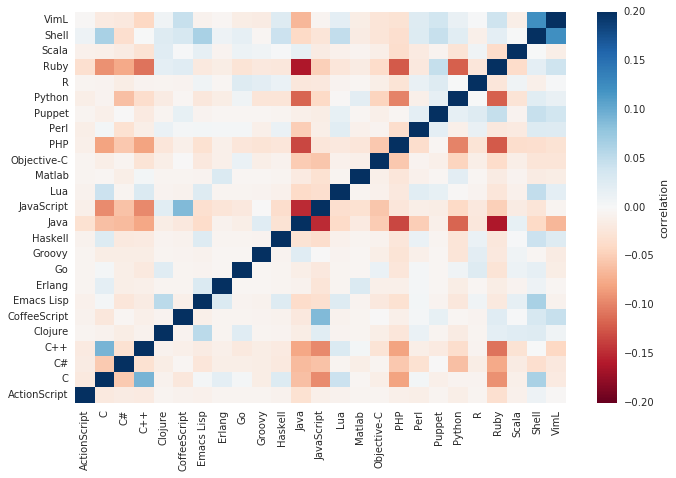

In [16]:
plot_correlation(corr)

# Takeaways and Observations

We can see that JavaScript and CSS pushes have strong positive correlation, as well as C and C++, and Objective-C and Swift (good sanity check).

* No surprise ... JavaScript is highly correlated with CSS, and C with C++. These are just good sanity checks.
* A bit surprising ... Java has some strong uncorrelations - with JavaScript, PHP and Ruby ... static vs. dynamic languages?
* Also surprising ... R seems not so correlated with Python?
* Go is not uncorrelated with anything other than Java, even if not highly correlated. Go programmers do not exclusively program in Go.
* And PHP is uncorrelated with many languages. Maybe a different developer persona altogether?